# Graph analysis for a legislature

## Config

In [2]:
import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.lines as mlines
from itertools import combinations


### Load the JSON files and create the graph

In [3]:
def load_data(deputies_path, votes_path):
    with open(deputies_path, 'r', encoding='utf-8') as f:
        deputies = json.load(f)
    with open(votes_path, 'r', encoding='utf-8') as f:
        votes = json.load(f)
    return {"deputies": deputies, "votes": votes}

In [4]:
def create_graph(deputies, votes):
    G = nx.Graph()
    for deputy_id, deputy_info in deputies.items():
        G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
    co_votes = {}
    deputy_votes = {}
    
    for vote_id, vote_data in votes.items():
        pour_voters = vote_data['votes_for']
        all_voters = set(pour_voters + vote_data['votes_against'] + vote_data['votes_abs'])
        
        for deputy in all_voters:
            if deputy not in deputy_votes:
                deputy_votes[deputy] = set()
            deputy_votes[deputy].add(vote_id)
        
        for i in range(len(pour_voters)):
            for j in range(len(pour_voters)):
                if i != j:
                    deputy1 = pour_voters[i]
                    deputy2 = pour_voters[j]
                    if G.has_node(deputy1) and G.has_node(deputy2):
                        pair = tuple(sorted([deputy1, deputy2]))
                        co_votes[pair] = co_votes.get(pair, 0) + 0.5 

    for (deputy1, deputy2), pour_count in co_votes.items():
        common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
        total_common = len(common_votes)
        if total_common > 0:
            percentage = pour_count / total_common
            G.add_edge(deputy1, deputy2, weight=percentage)
            
    return G

In [5]:
def print_stats(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    if nx.is_connected(G):
        print("Graph is connected")
    else:
        print(f"Graph has {nx.number_connected_components(G)} connected components")

def get_giant_component(G):
    gcc_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(gcc_nodes).copy()

In [6]:
def plot_network(G, deputies):
    nodes_color = [deputies[node].get('organ',{}).get('color','#cccccc') for node in G.nodes()]
    party_colors = {deputies[node].get('organ',{}).get('color','#cccccc'):deputies[node].get('organ',{}).get('name','No name') for node in G.nodes()}
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=500, iterations=50, weight='weight', seed=42)
    nx.draw(G, pos, node_size=100, node_color=nodes_color, edge_color='lightgray', alpha=0.7, with_labels=False, width=edge_weights)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=name, markerfacecolor=color, markersize=10) for color, name in party_colors.items()], title="Political Parties", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Deputy Voting Network")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_degree_distribution(G):
    degrees = dict(G.degree(weight='weight'))
    degree_values = list(degrees.values())
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
    degree_counts = Counter(degree_values)
    ks = sorted(degree_counts.keys())
    counts = [degree_counts[k] for k in ks]
    axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [8]:
def detect_communities(G):
    communities_set = nx.community.louvain_communities(G, weight="weight")
    num_communities = len(communities_set)
    partition = {}
    for community_id, nodes in enumerate(communities_set):
        for node in nodes:
            partition[node] = community_id
    
    cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
    nodes_color_com = [cmap(partition[node]) for node in G.nodes()]
    
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i}', markerfacecolor=cmap(i), markersize=10) for i in range(num_communities)]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=500, iterations=50, weight= 'weight', seed=42)
    nx.draw(G, 
            pos, 
            node_size=100, node_color=nodes_color_com, 
            edge_color='lightgray',
            alpha=0.7, with_labels=False, width=0.1)
    plt.legend(handles=legend_handles,
            title="Computed communities", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Deputy Voting Network - Computed louvain communities (louvain)")
    plt.tight_layout()
    plt.show()

    print(f'Number of communities : {len(communities_set)}')
    modularity_score = nx.community.modularity(G, communities_set, weight='weight')
    print(f"Modularity score : {modularity_score}")
    return communities_set, modularity_score

In [9]:
def get_party_info(deputies):
    organ_name_dict = {}
    partis_members = {}
    for dep_id, data in deputies.items():
        if data['organ']:
            organ_id = data['organ']['id']
            organ_name_dict[organ_id] = (data['organ']['name'], data['organ']['name_short'])
            if organ_id not in partis_members:
                partis_members[organ_id] = []
            partis_members[organ_id].append(dep_id)
    return organ_name_dict, partis_members

In [10]:
def plot_community_matrix(partis_members, communities_set, organ_name_dict, all_member_ids):
    communities_dict = {f"C{i}": comm for i, comm in enumerate(communities_set)}
    community_tuples = []
    sorted_comm_keys = sorted(communities_dict.keys())
    for comm_key in sorted_comm_keys:
        comm_set = communities_dict[comm_key]
        members_in_comm = [item for item in comm_set if item in all_member_ids]
        community_tuples.append((comm_key, members_in_comm))
    
    party_member_lists = list(partis_members.values())
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(num_parti):
        party_i_members = party_member_lists[i]
        for j in range(num_commu):
            community_j_members = community_tuples[j][1]
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            num_party_members = len(party_i_members)
            if num_party_members > 0:
                D[i, j] *= 100 / num_party_members
            else:
                D[i, j] = 0

    x_labels = [f"{t[0]}\n(Size: {len(t[1])})" for t in community_tuples]
    y_labels = [organ_name_dict[g][1] for g in list(partis_members.keys())]
    
    plt.figure(figsize=(max(8, num_commu * 2.5), max(6, num_parti * 0.8)))
    sns.heatmap(D, annot=True, fmt='.0f', cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)
    plt.title('Normalized by Party Size (%)')
    plt.tight_layout()
    plt.show()

In [11]:
def analyze_party_proximity(G, partis_members, organ_name_dict, deputies, plot):
    list_partis = list(partis_members.keys())
    proximites_partis = {}
    proximites_without_parties = {} # Between parties
    
    # Between parties
    for i in range(len(list_partis)-1):
        for j in range(i+1, len(list_partis)):
            proximites = []
            for member_i in partis_members[list_partis[i]]:
                for member_j in partis_members[list_partis[j]]:
                    if G.has_node(member_i) and G.has_node(member_j):
                        weigth = 0
                        if G.has_edge(member_i, member_j):
                            weigth = G[member_i][member_j]['weight']

                        proximites_without_parties[(member_i, member_j)] = weigth
                        proximites.append(weigth)
            if proximites:
                proximites_partis[(list_partis[i], list_partis[j])] = np.mean(proximites)

    # Total 
    proximites_debuties = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_debuties[(i, j)] = weight

    # Within parties
    proximites_within_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_parties[(m1, m2)] = weight

    # Of parties
    proximites_of_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight
        party_name = organ_name_dict.get(parti, (parti, parti))[1]
        proximites_of_parties[parti] = {"parti": parti, "name": party_name, "combinations": tmp}
        
    if plot:
        G_partis = nx.Graph()
        labels_dict = {}
        for parti_id, members in partis_members.items():
            nom_parti = organ_name_dict.get(parti_id, (parti_id, parti_id))[1]
            G_partis.add_node(parti_id, count=len(members), label_name=nom_parti)
            labels_dict[parti_id] = f"{nom_parti}\n({len(members)})"

        for (p1, p2), dist in proximites_partis.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_partis.add_edge(p1, p2, distance=dist, weight=1.0/safe_dist)

        node_colors = []
        for parti_id in G_partis.nodes():
            color = '#cccccc'
            members = partis_members.get(parti_id, [])
            if members and members[0] in deputies:
                color = deputies[members[0]].get('organ', {}).get('color', '#cccccc')
            node_colors.append(color)

        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G_partis, weight='weight', k=0.6, seed=42)
        nx.draw_networkx_nodes(G_partis, pos, node_size=[G_partis.nodes[n]['count'] * 50 for n in G_partis.nodes()], node_color=node_colors, alpha=0.9, edgecolors='white')
        nx.draw_networkx_labels(G_partis, pos, labels=labels_dict, font_size=8, font_weight='bold')
        nx.draw_networkx_edges(G_partis, pos, width=1, alpha=0.3, edge_color='gray')
        plt.axis('off')
        plt.show()
        
        parties_ids = list(G_partis.nodes())
        parties_names = [G_partis.nodes[pid]['label_name'] for pid in parties_ids]
        dist_matrix = pd.DataFrame(np.nan, index=parties_names, columns=parties_names)
        for (p1, p2), dist in proximites_partis.items():
            if p1 in parties_ids and p2 in parties_ids:
                name1 = G_partis.nodes[p1]['label_name']
                name2 = G_partis.nodes[p2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist
                
        plt.figure(figsize=(14, 12))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis_r", linewidths=0.5)
        plt.title("Proximity matrix between parties")
        plt.show()

    print(len(proximites_partis), len(proximites_without_parties), len(proximites_debuties), len(proximites_within_parties), len(proximites_of_parties))

    return proximites_partis, proximites_without_parties, proximites_debuties, proximites_within_parties, proximites_of_parties

In [12]:
def calculate_party_modularity(G, partis_members):
    nodes_in_graph = set(G.nodes())
    cleaned_parti_com = []
    for members in partis_members.values():
        valid_members = [m for m in members if m in nodes_in_graph]
        if valid_members:
            cleaned_parti_com.append(valid_members)
    mod = nx.community.modularity(G, cleaned_parti_com, weight='weight')
    return mod

In [13]:
legislature_17 = load_data('data/processed/deputees_17.json', 'data/processed/vote_17.json')
legislature_16 = load_data('data/processed/deputees_16.json', 'data/processed/vote_16.json')
legislature_15 = load_data('data/processed/deputees_15.json', 'data/processed/vote_15.json')
legislature_14 = load_data('data/processed/deputees_14.json', 'data/processed/vote_14.json')

In [14]:
for num, data in [(14, legislature_14), (15, legislature_15), (16, legislature_16), (17, legislature_17)]:
    deps = data.get("deputies", {})
    votes = data.get("votes", {})
    print(f"Legislature {num}: deputies={len(deps)}, votes={len(votes)}")

Legislature 14: deputies=642, votes=1354
Legislature 15: deputies=689, votes=4417
Legislature 16: deputies=643, votes=4106
Legislature 17: deputies=646, votes=3404


In [15]:
G_17 = get_giant_component(create_graph(legislature_17["deputies"], legislature_17["votes"]))
G_16 = get_giant_component(create_graph(legislature_16["deputies"], legislature_16["votes"]))
G_15 = get_giant_component(create_graph(legislature_15["deputies"], legislature_15["votes"]))
G_14 = get_giant_component(create_graph(legislature_14["deputies"], legislature_14["votes"]))

In [16]:
organ_name_dict_17, partis_members_17 = get_party_info(legislature_17["deputies"])
organ_name_dict_16, partis_members_16 = get_party_info(legislature_16["deputies"])
organ_name_dict_15, partis_members_15 = get_party_info(legislature_15["deputies"])
organ_name_dict_14, partis_members_14 = get_party_info(legislature_14["deputies"])

In [17]:
party_mod_17 = calculate_party_modularity(G_17, partis_members_17)
party_mod_16 = calculate_party_modularity(G_16, partis_members_16)
party_mod_15 = calculate_party_modularity(G_15, partis_members_15)
party_mod_14 = calculate_party_modularity(G_14, partis_members_14)

C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\1283008352.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\1283008352.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


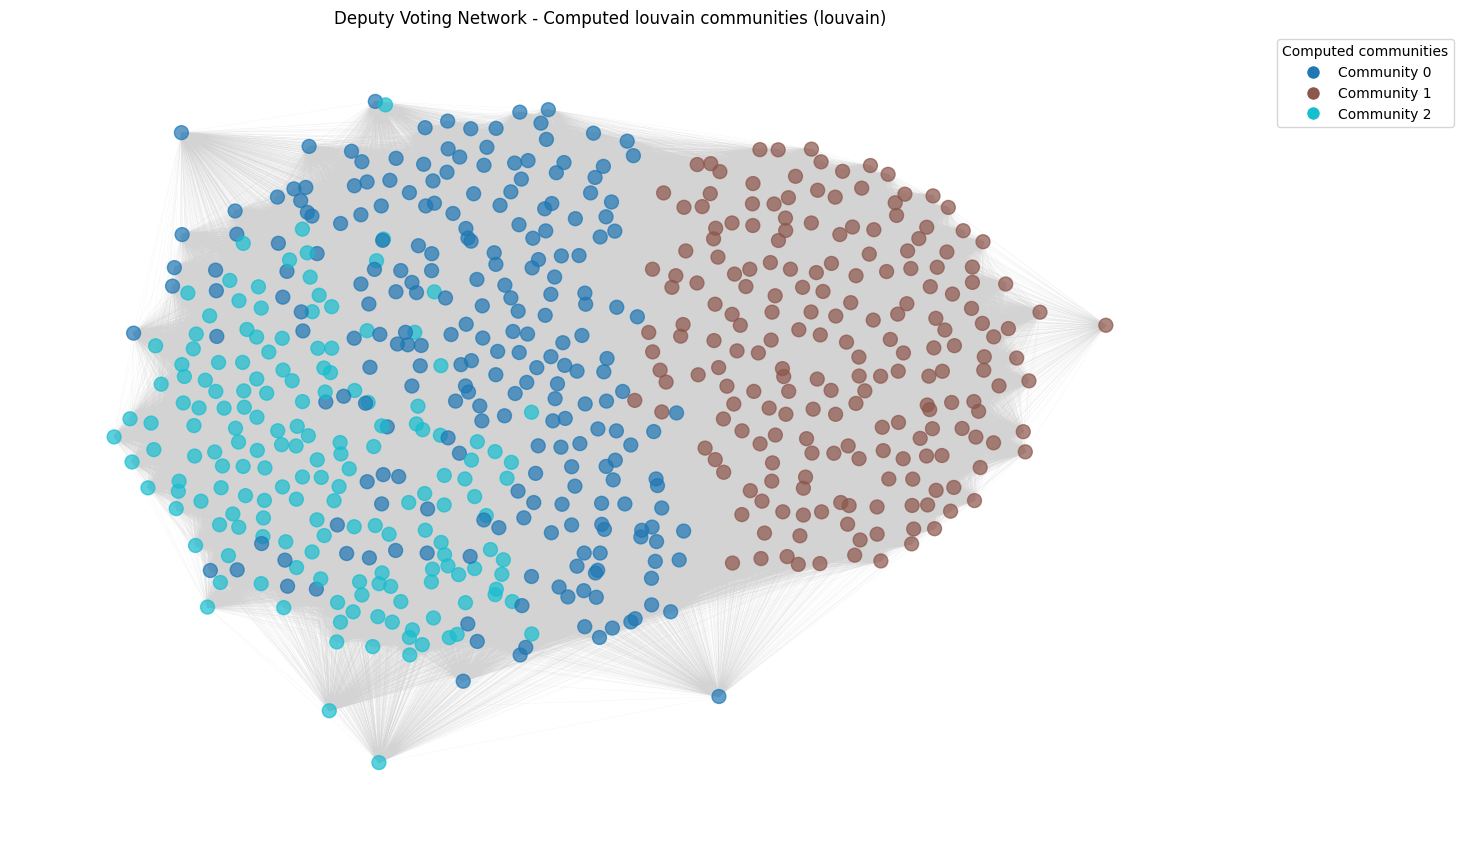

Number of communities : 3
Modularity score : 0.19481303921877385


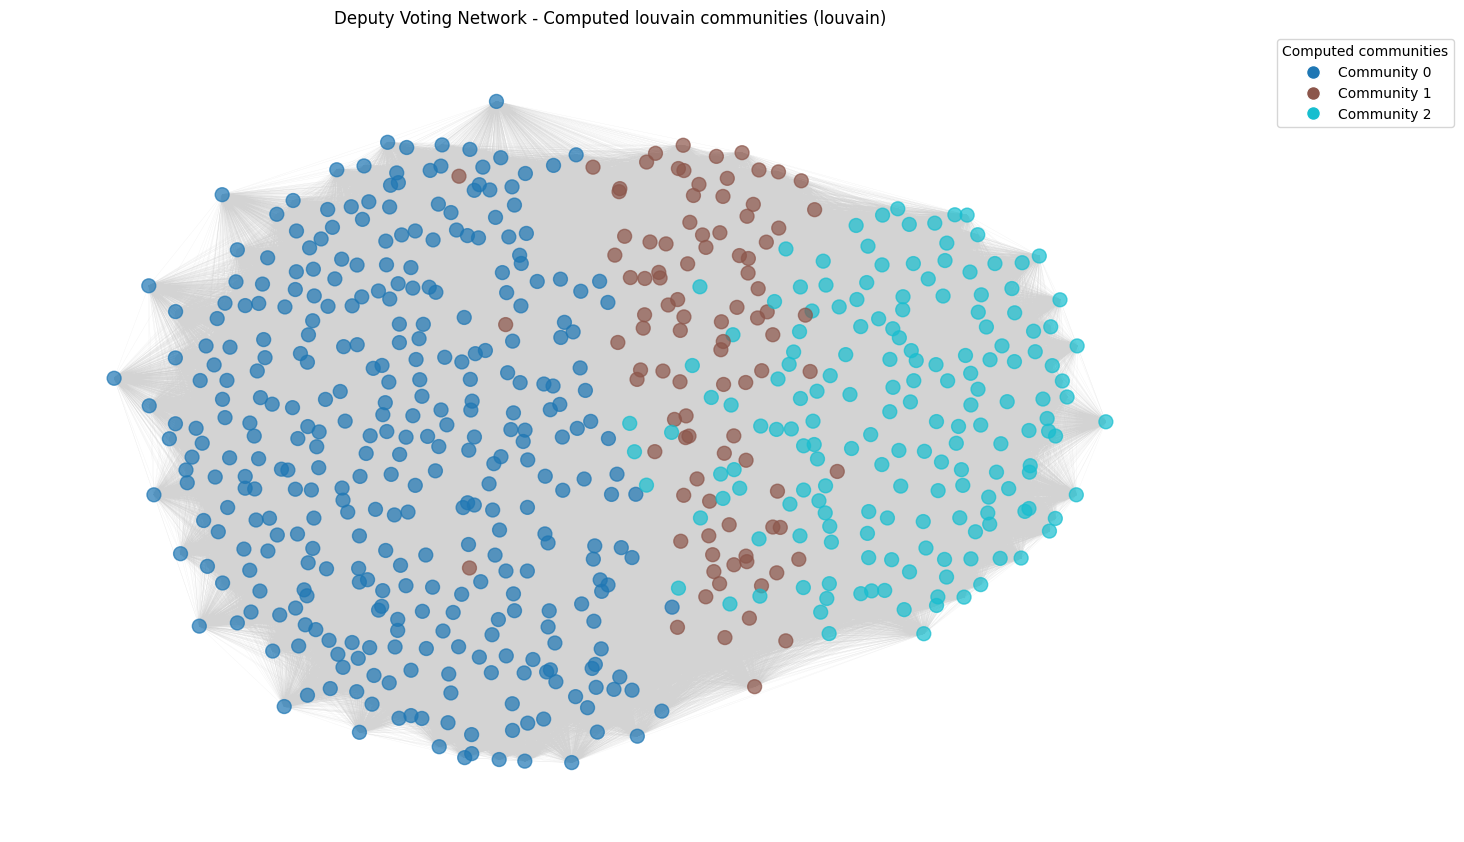

Number of communities : 3
Modularity score : 0.21062038391537935


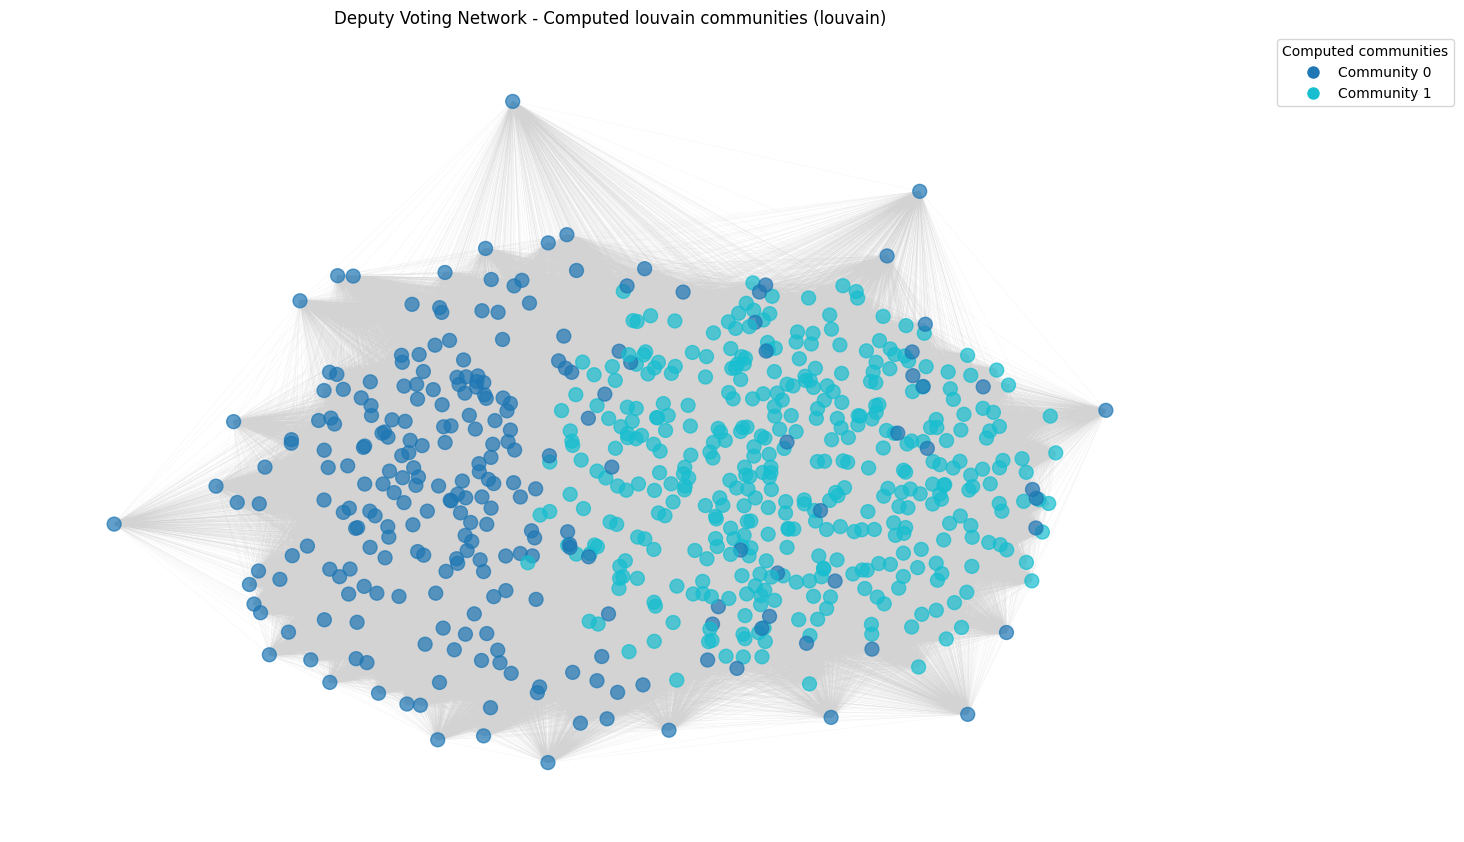

Number of communities : 2
Modularity score : 0.12463631146675501


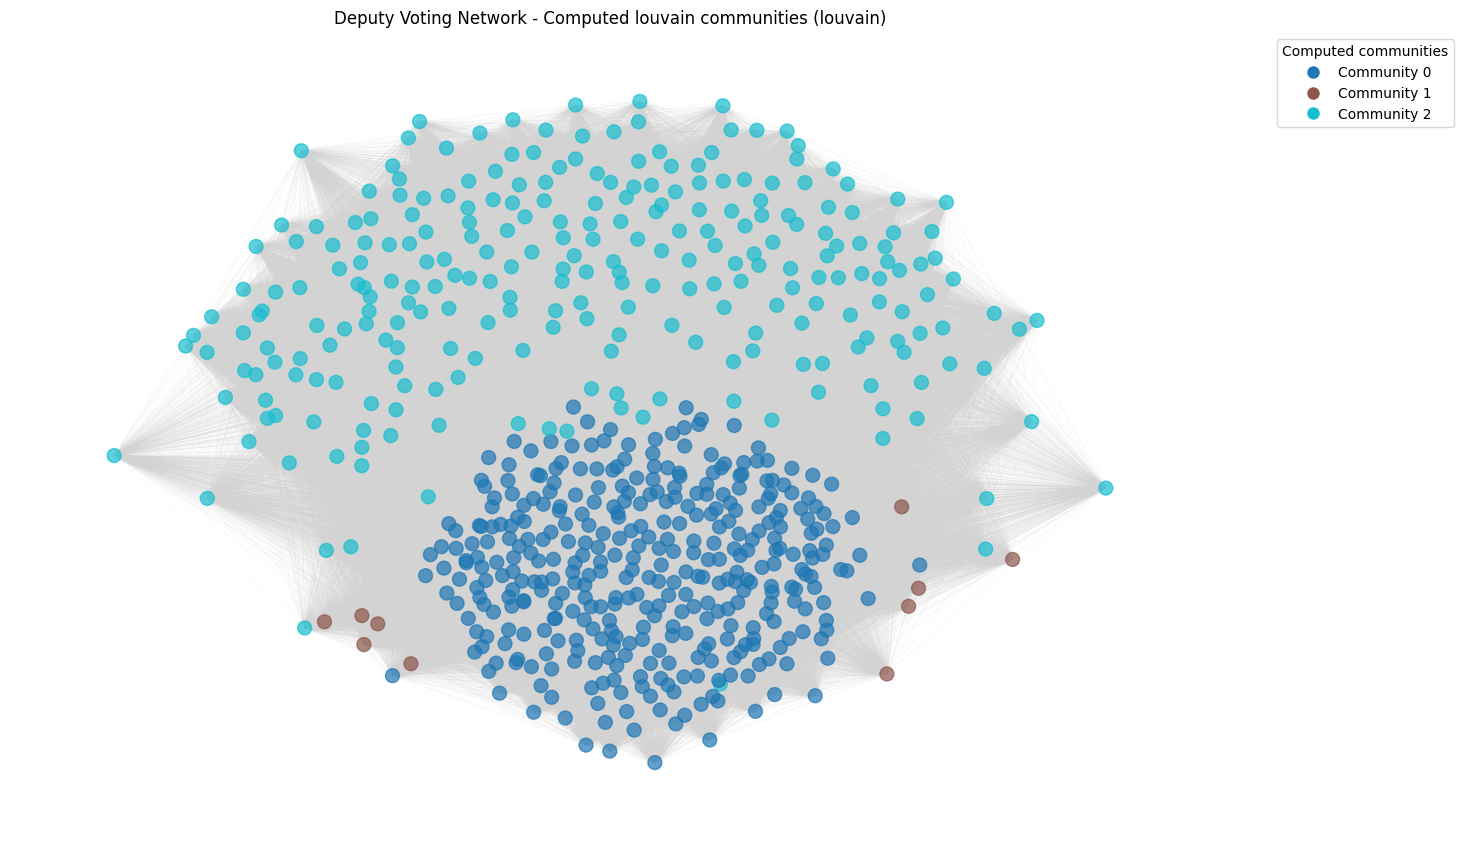

Number of communities : 3
Modularity score : 0.11212378480255555


In [18]:
communities_set_17, louv_mod_17 = detect_communities(G_17)
communities_set_16, louv_mod_16 = detect_communities(G_16)
communities_set_15, louv_mod_15 = detect_communities(G_15)
communities_set_14, louv_mod_14 = detect_communities(G_14)

In [32]:
for leg, organ_name_dict, partis_members in [
    (14, organ_name_dict_14, partis_members_14),
    (15, organ_name_dict_15, partis_members_15),
    (16, organ_name_dict_16, partis_members_16),
    (17, organ_name_dict_17, partis_members_17),
]:
    total_parties = len(organ_name_dict)
    parties_with_members = sum(1 for pid in organ_name_dict if len(partis_members.get(pid, [])) > 0)
    print(f"Legislature {leg}: total parties = {total_parties}, parties with members = {parties_with_members}")
    # sort by short name if available, else by full name
    for organ_id, (name, name_short) in sorted(organ_name_dict.items(), key=lambda kv: (kv[1][1] or kv[1][0])):
        count = len(partis_members.get(organ_id, []))
        print(f"  {name_short} ({organ_id}): {count} members — {name}")
    print()

Legislature 14: total parties = 9, parties with members = 9
  GDR (PO656018): 15 members — Gauche démocrate et républicaine
  Les Républicains (PO707869): 205 members — Les Républicains
  NI (PO645633): 25 members — Non inscrit
  RRDP (PO656022): 20 members — Radical, républicain, démocrate et progressiste
  SER (PO713077): 291 members — Socialiste, écologiste et républicain
  SRC (PO656002): 49 members — Socialiste, républicain et citoyen
  UDI (PO656010): 32 members — Union des démocrates et indépendants
  UMP (PO656006): 3 members — Union pour un Mouvement Populaire
  Écolo (PO656014): 2 members — Écologiste

Legislature 15: total parties = 13, parties with members = 13
  Agir ens (PO771923): 23 members — Agir ensemble
  Dem (PO774834): 60 members — Mouvement Démocrate (MoDem) et Démocrates apparentés
  FI (PO730958): 17 members — La France insoumise
  GDR (PO730940): 18 members — Gauche démocrate et républicaine
  LR (PO730934): 119 members — Les Républicains
  LT (PO759900): 18 me

In [20]:
proximites_partis_17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17 = analyze_party_proximity(G_17, partis_members_17, organ_name_dict_17, legislature_17["deputies"], False)
proximites_partis_16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16 = analyze_party_proximity(G_16, partis_members_16, organ_name_dict_16, legislature_16["deputies"], False)
proximites_partis_15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15 = analyze_party_proximity(G_15, partis_members_15, organ_name_dict_15, legislature_15["deputies"], False)
proximites_partis_14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14 = analyze_party_proximity(G_14, partis_members_14, organ_name_dict_14, legislature_14["deputies"], False)

78 159635 181503 21868 12
55 153933 182710 28777 11
78 154345 208981 54636 13
36 136482 201295 64813 9


In [21]:
def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def plot_proximity_comparison(prox_between, prox_total, prox_within, prox_of_parties, deputies, legislature_id):
    plt.figure(figsize=(14, 9))
    
    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.1, color='grey', linestyle='--', linewidth=2)
    sns.kdeplot(list(prox_within.values()), label='Within Parties (All)', fill=True, alpha=0.1, color='black', linewidth=2)
    #sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.1)

    party_colors = {}
    for dep in deputies.values():
        if dep.get('organ'):
            party_colors[dep['organ']['id']] = dep['organ'].get('color', '#cccccc')

    for party_id, data in prox_of_parties.items():
        vals = list(data['combinations'].values())
        if len(vals) > 5: # Filter slightly to avoid KDE errors on very few points
            color = party_colors.get(party_id, '#cccccc')
            sns.kdeplot(vals, label=f"{data['name']}", color=color, linestyle=':', linewidth=3.5, alpha=0.9)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}', fontsize=16)
    plt.xlabel('Proximity (Weight)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_proximity_comparison2(prox_between, prox_total, prox_within, legislature_id):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.3)
    sns.kdeplot(list(prox_within.values()), label='Within Parties', fill=True, alpha=0.3)
    sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.3)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}')
    plt.xlabel('Proximity (Weight)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_proximity_comparison_vertical_all(data_list):
    fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
    
    for i, (leg_id, prox_between, prox_total, prox_within) in enumerate(data_list):
        ax = axes[i]
        
        sns.kdeplot(y=list(prox_between.values()), ax=ax, label='Between Parties', fill=True, alpha=0.3)
        sns.kdeplot(y=list(prox_within.values()), ax=ax, label='Within Parties', fill=True, alpha=0.3)
        sns.kdeplot(y=list(prox_total.values()), ax=ax, label='Total', fill=True, alpha=0.3)
        
        ax.set_title(f'Legislature {leg_id}')
        ax.set_xlabel('Density')
        if i == 0:
            ax.set_ylabel('Proximity (Weight)')
        else:
            ax.set_ylabel('')
            
        if i == 3:
            ax.legend(loc='upper right')
        else:
            ax.get_legend().remove() if ax.get_legend() else None

    plt.tight_layout()
    plt.show()

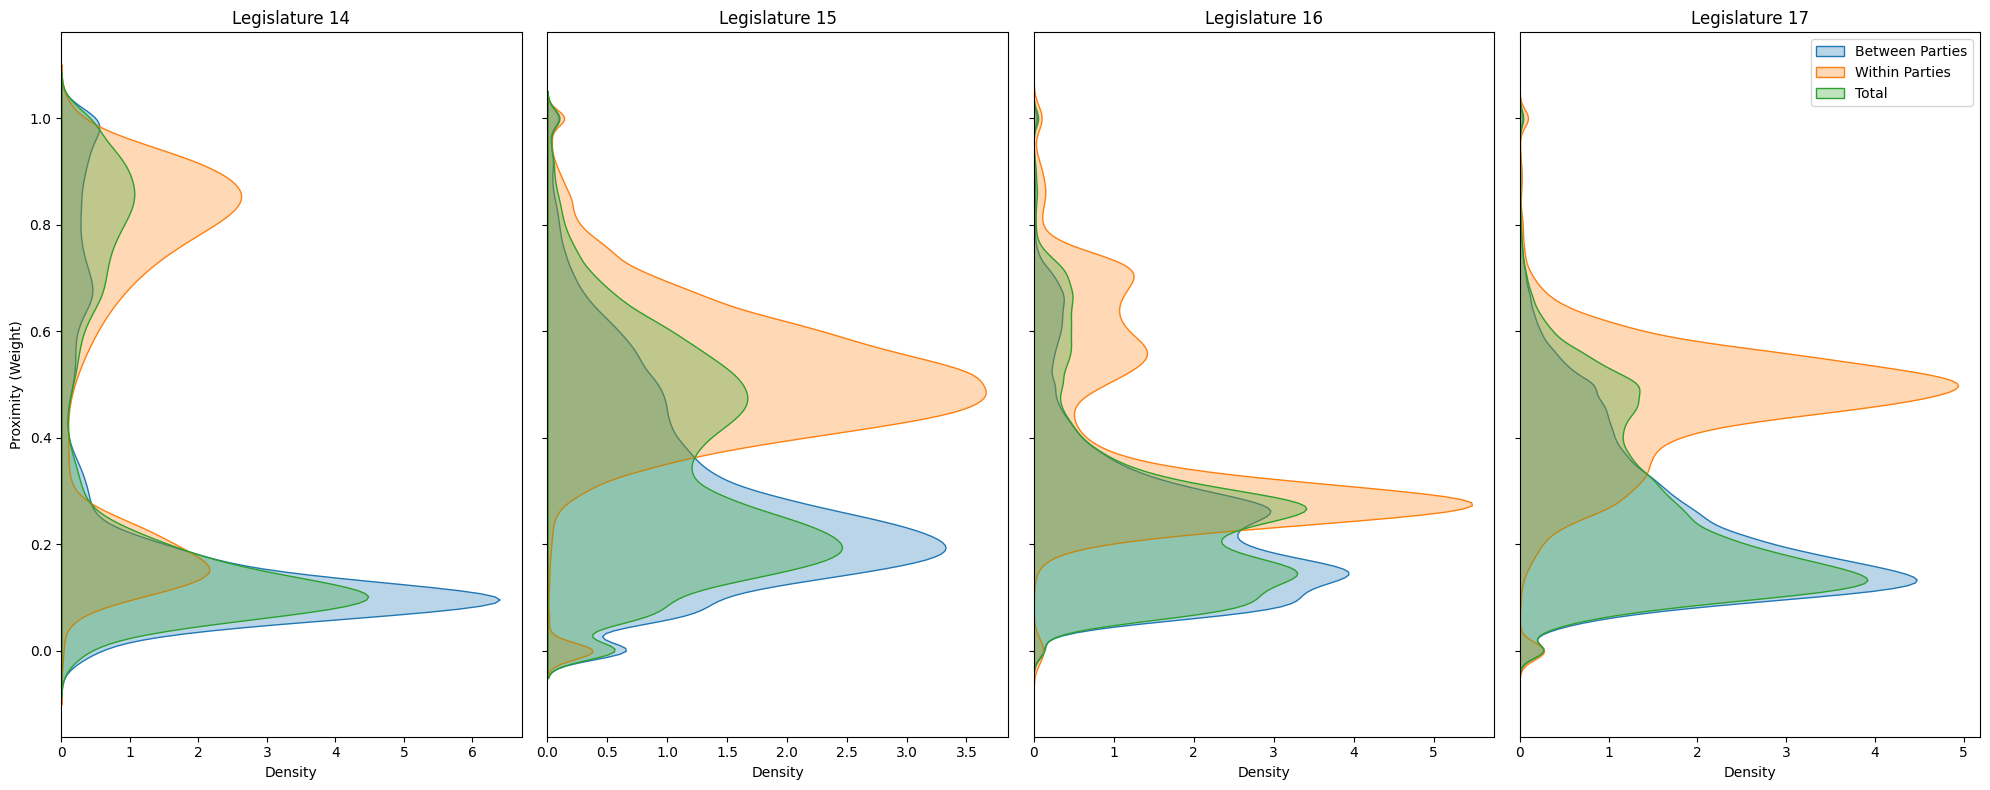

In [22]:
data_for_vertical_plot = [
    (14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14),
    (15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15),
    (16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16),
    (17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17)
]
plot_proximity_comparison_vertical_all(data_for_vertical_plot)

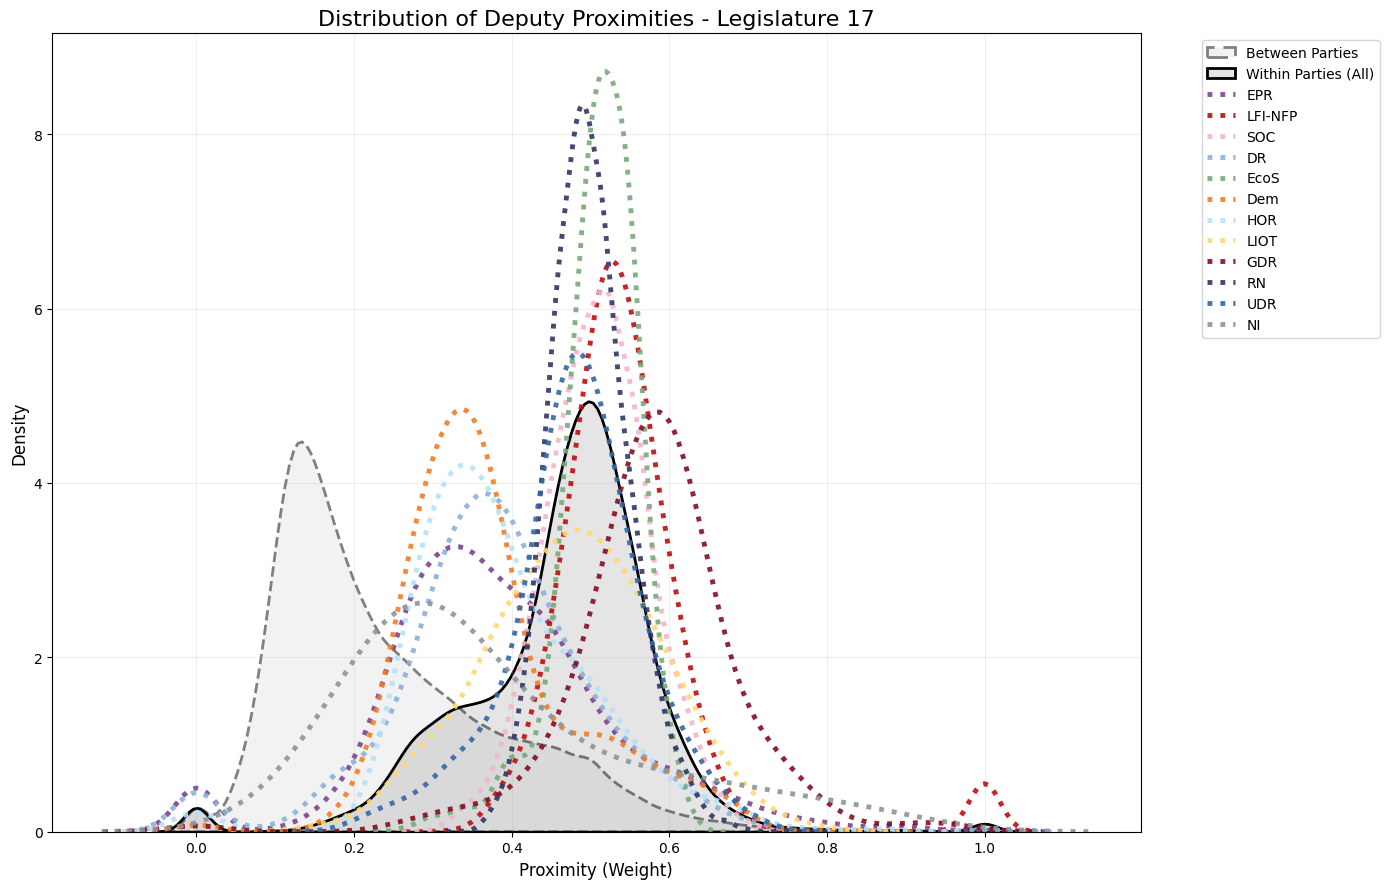

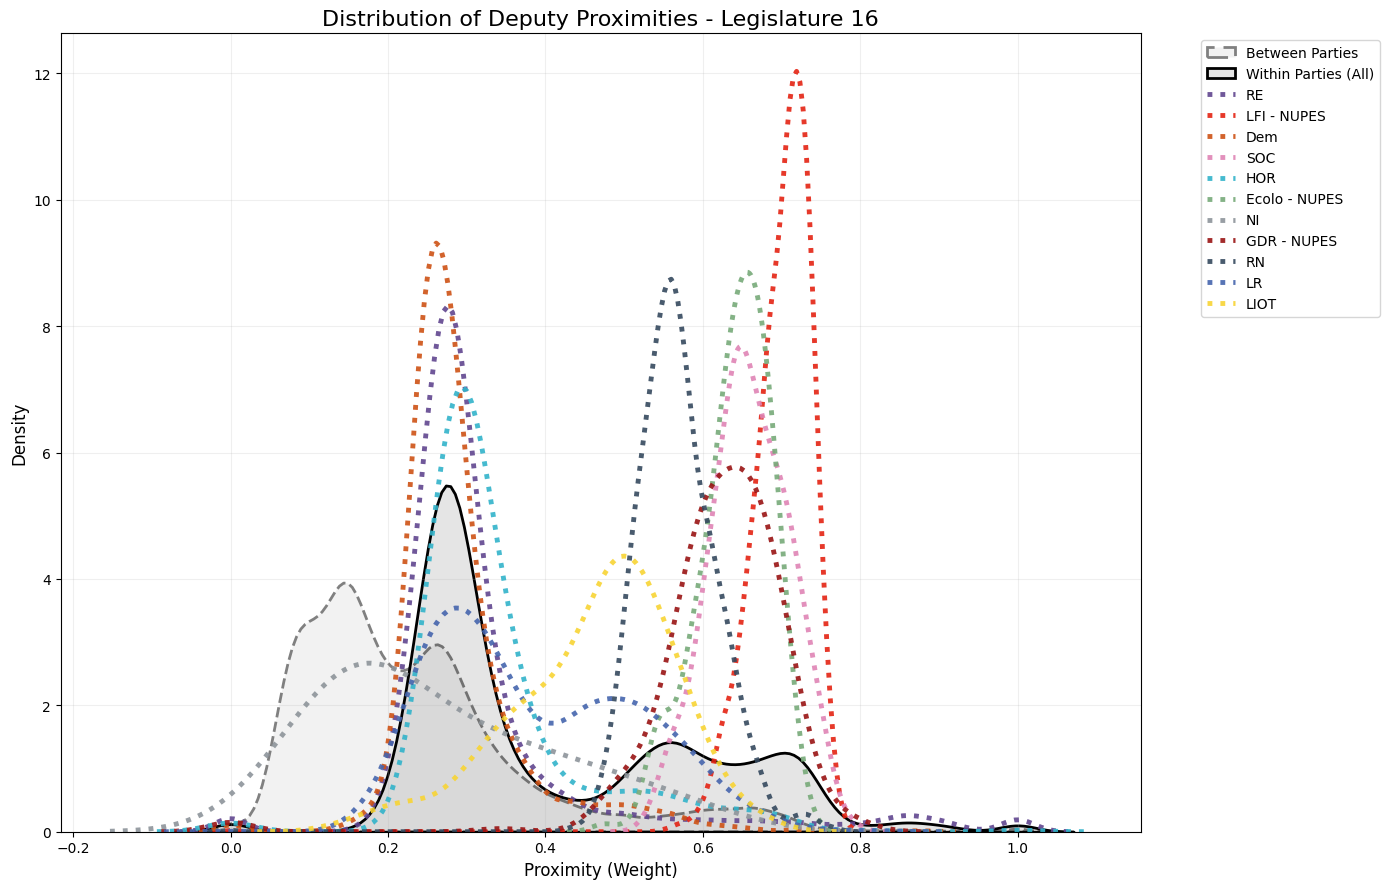

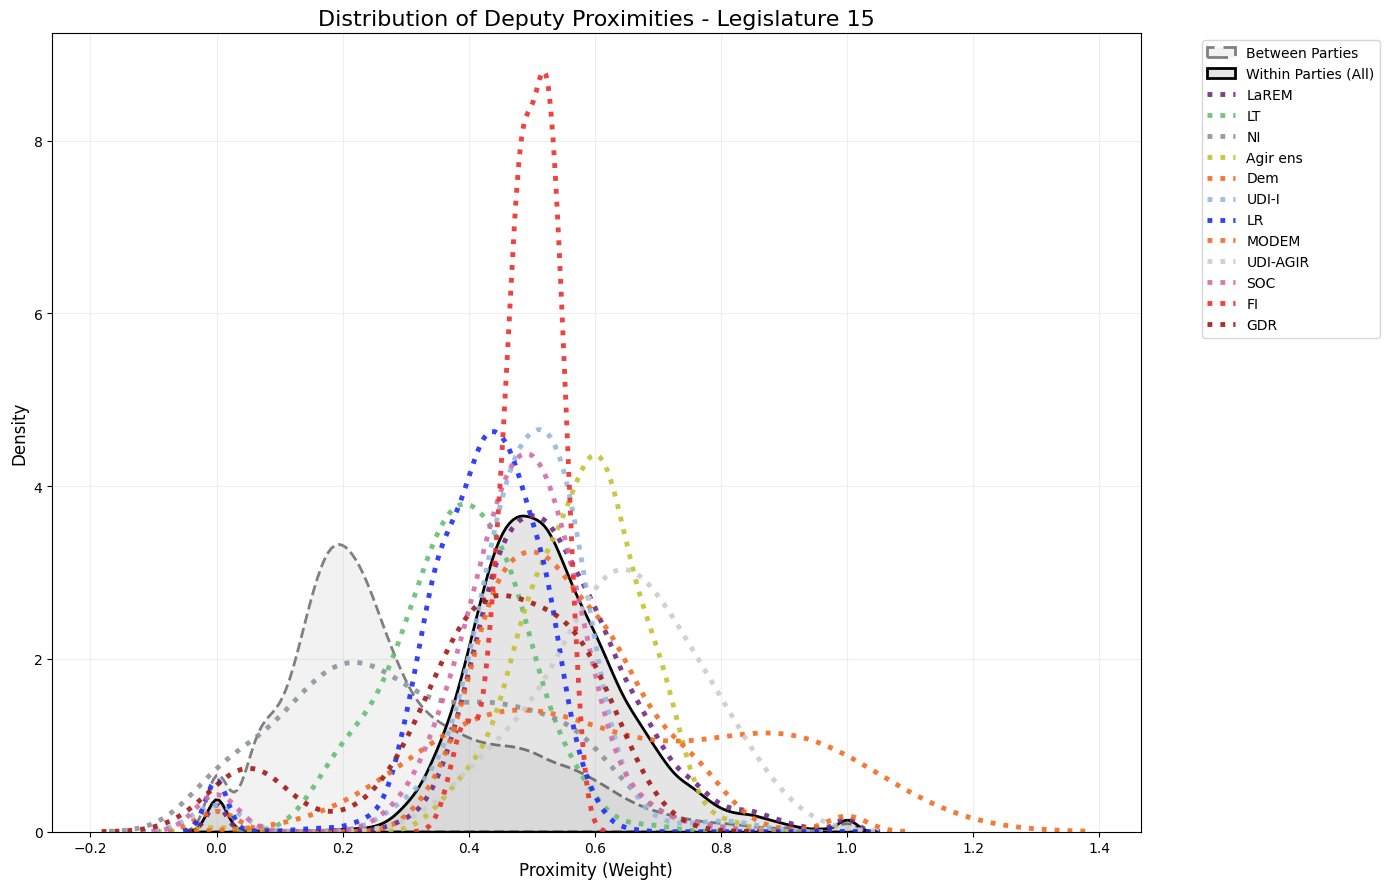

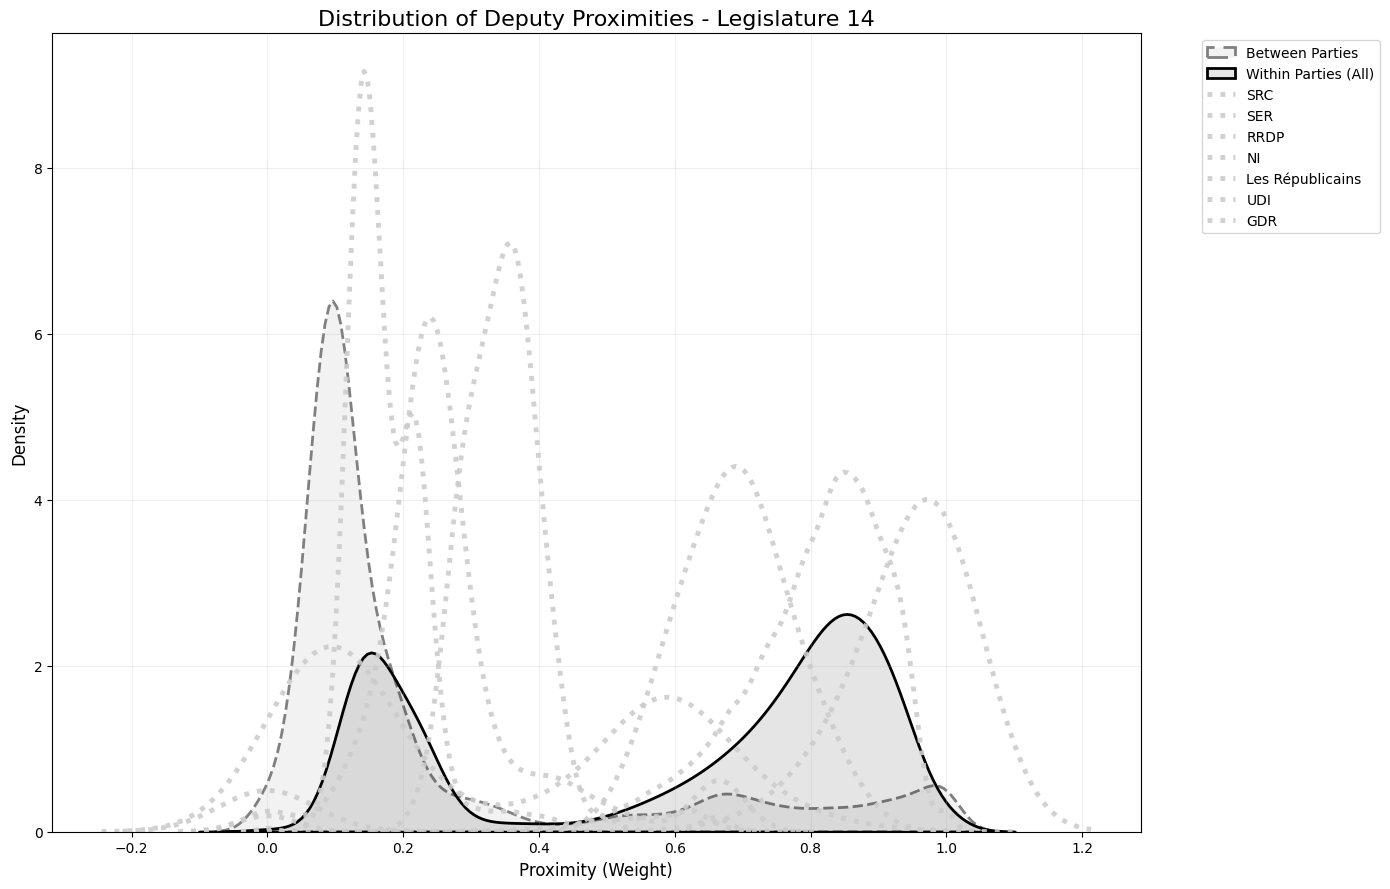

In [23]:
plot_proximity_comparison(proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17, legislature_17["deputies"], 17)
plot_proximity_comparison(proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16, legislature_16["deputies"], 16)
plot_proximity_comparison(proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15, legislature_15["deputies"], 15)
plot_proximity_comparison(proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14, legislature_14["deputies"], 14)


Number of nodes: 646
Number of edges: 179915
Average degree: 557.01
Graph has 44 connected components


C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\1722227690.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


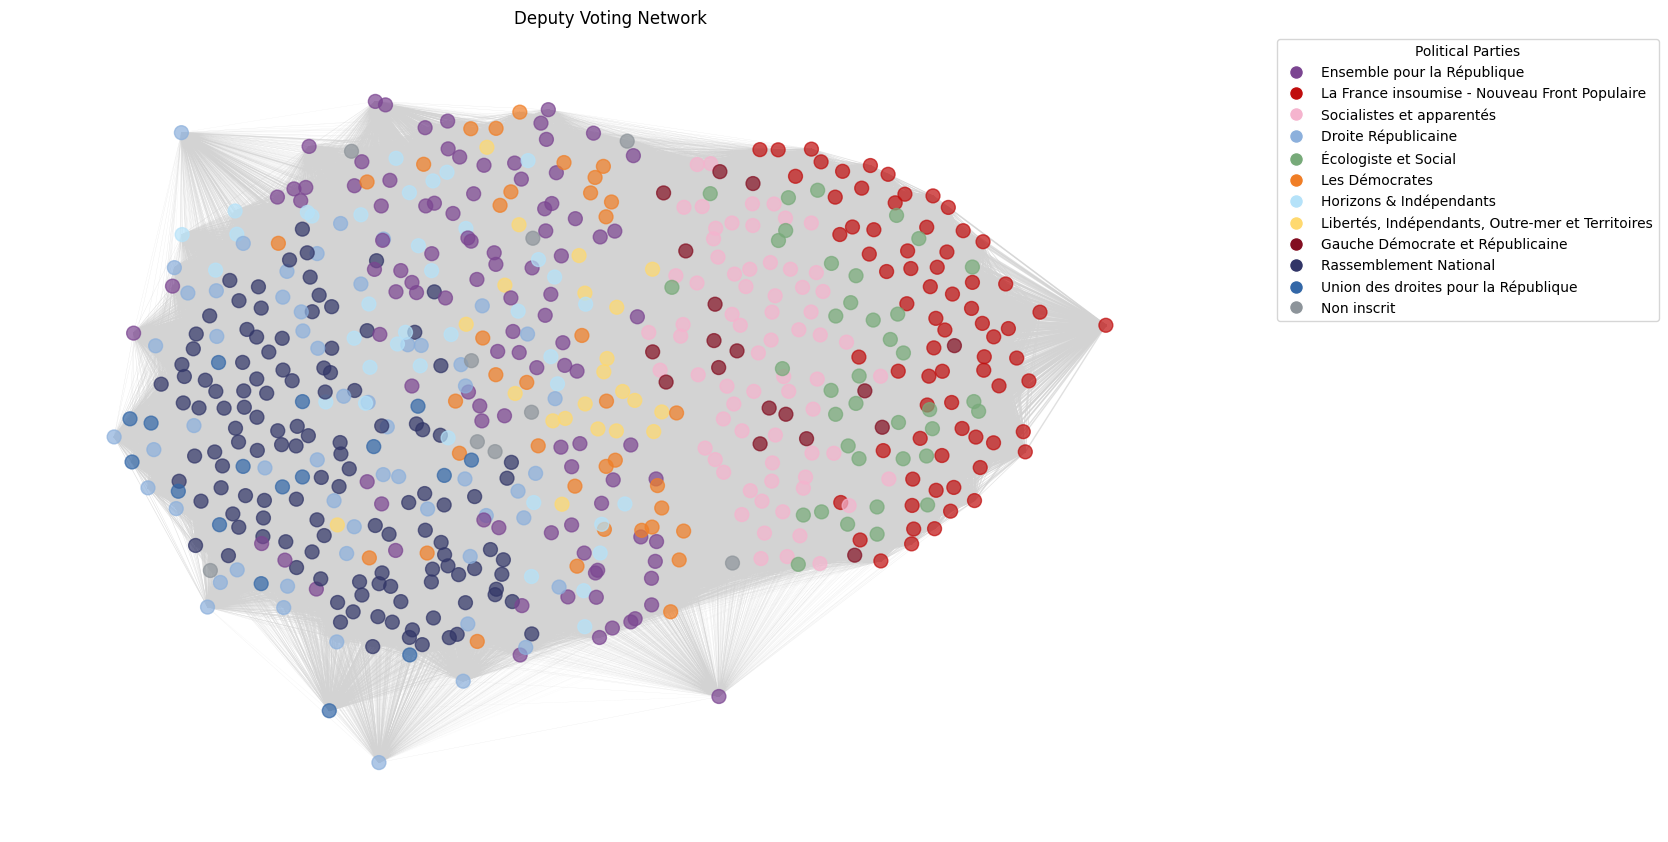

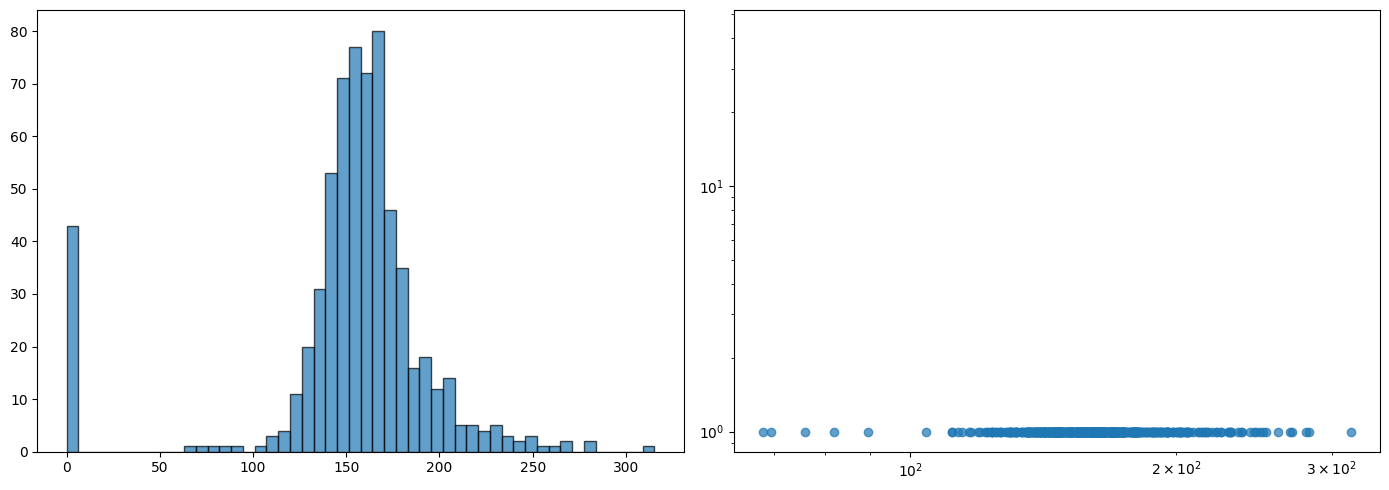

C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\1283008352.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\1283008352.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


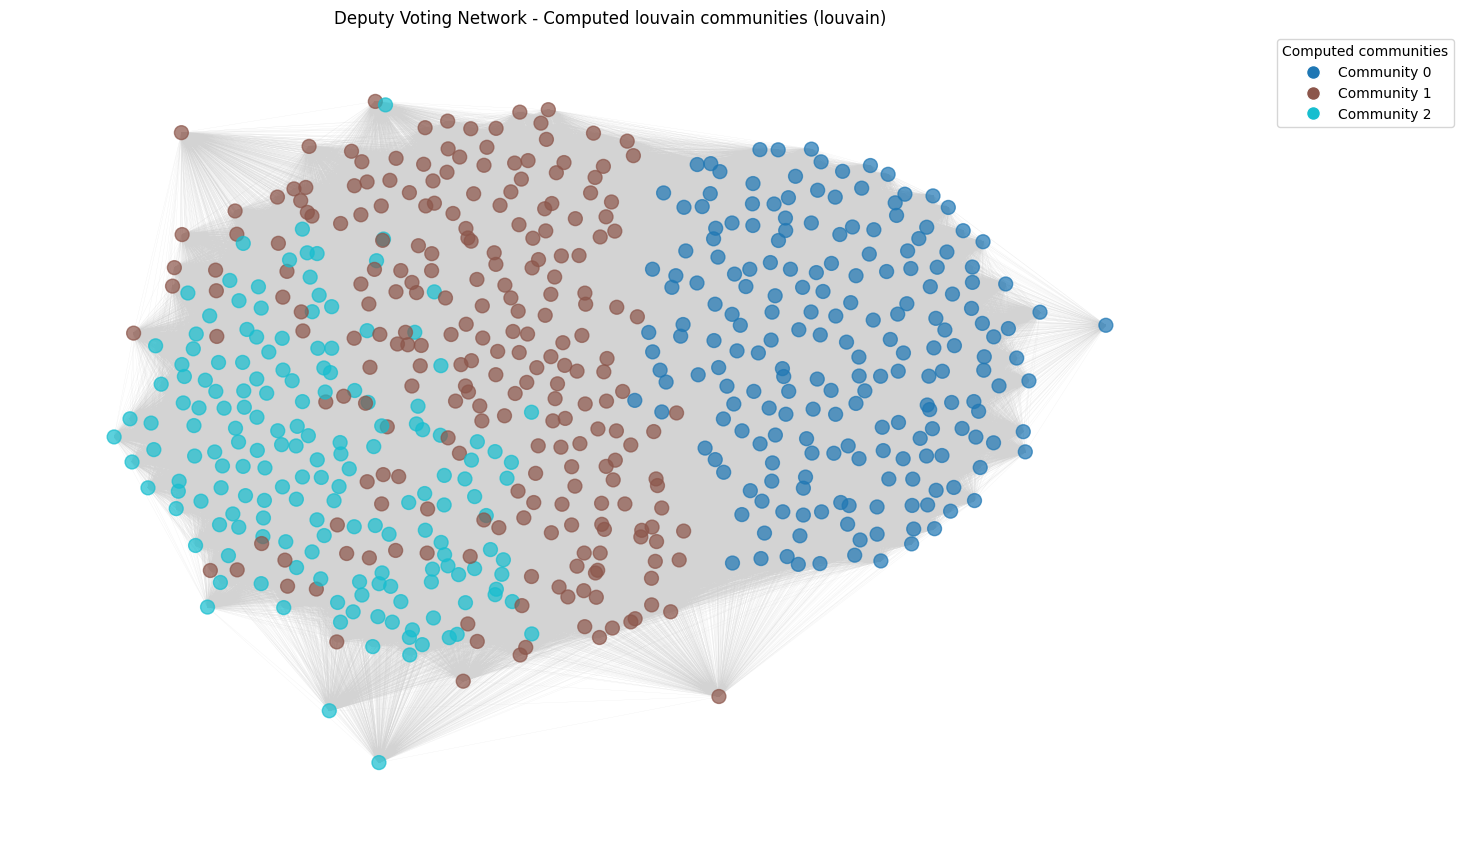

Number of communities : 3
Modularity score : 0.19481310466614432


In [24]:
G = create_graph(legislature_17["deputies"], legislature_17["votes"])
print_stats(G)
G_sample = get_giant_component(G)
plot_network(G_sample, legislature_17["deputies"])
plot_degree_distribution(G)
communities_set, modularity_score = detect_communities(G_sample)


In [25]:
def print_legislature_summary_table(data_list):
    rows = []
    for leg_id, G, communities_set, louvain_mod, party_mod in data_list:
            
        num_communities = len(communities_set)
        density = nx.density(G)
        print("da")
        avg_clustering = nx.average_clustering(G, weight='weight')
        
        rows.append({
            "Legislature": leg_id,
            "Num Communities": num_communities,
            "Modularity": party_mod,
            "Louvain Modularity": louvain_mod,
            "Density": density,
            "Avg Clustering": avg_clustering
        })
    
    df = pd.DataFrame(rows)
    return df

In [26]:
summary_data = [
    (17, G_17, communities_set_17, louv_mod_17, party_mod_17),
    (16, G_16, communities_set_16, louv_mod_16, party_mod_16),
    (15, G_15, communities_set_15, louv_mod_15, party_mod_15),
    (14, G_14, communities_set_14, louv_mod_14, party_mod_14)
]

print_legislature_summary_table(summary_data)

da
da
da
da


Legislature  Num Communities  Modularity  Louvain Modularity   Density  \
0           17                3    0.085430            0.194813  0.991251   
1           16                3    0.100254            0.210620  0.995725   
2           15                2    0.065435            0.124636  0.977974   
3           14                3    0.075174            0.112124  0.985633   

   Avg Clustering  
0        0.247351  
1        0.234634  
2        0.327405  
3        0.303035

C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\3883932454.py:65: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df, x="Legislature", y="Proximity", hue="Party Group",
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_62408\3883932454.py:65: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=df, x="Legislature", y="Proximity", hue="Party Group",


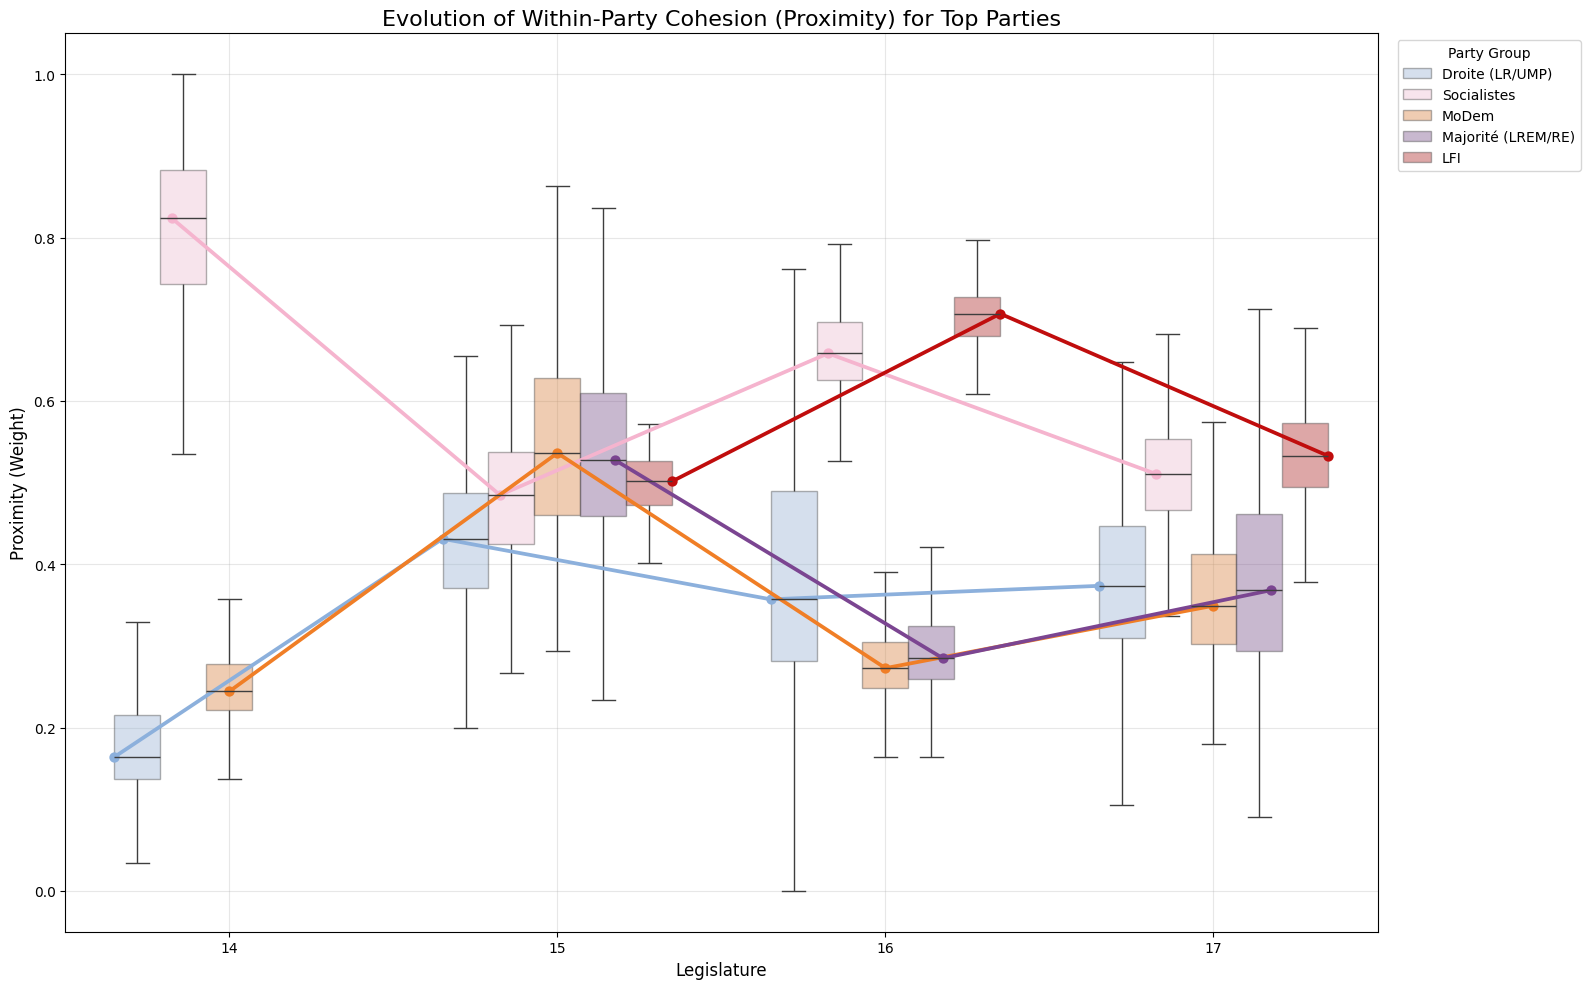

In [27]:
def plot_top_parties_cohesion(legislatures_data):
    # Mapping from prompt
    party_groups = {
        "Droite (LR/UMP)": {
            14: "PO707869", 15: "PO730934", 16: "PO800508", 17: "PO845425"
        },
        "Socialistes": {
            14: "PO713077", 15: "PO758835", 16: "PO830170", 17: "PO845419"
        },
        "MoDem": {
            14: "PO656010", 15: "PO774834", 16: "PO800484", 17: "PO845454"
        },
        "Majorité (LREM/RE)": {
            15: "PO730964", 16: "PO800538", 17: "PO845407"
        },
        "LFI": {
            15: "PO730958", 16: "PO800490", 17: "PO845413"
        }
    }

    plot_data = []
    palette = {}

    # legislatures_data is list of (leg_id, prox_of_parties, deputies)
    for leg_id, prox_of_parties, deputies in legislatures_data:
        
        # Build color map for this legislature
        party_colors = {}
        for dep in deputies.values():
            if dep.get('organ'):
                party_colors[dep['organ']['id']] = dep['organ'].get('color', '#cccccc')

        for group_name, mapping in party_groups.items():
            if leg_id in mapping:
                party_id = mapping[leg_id]
                
                if party_id in prox_of_parties:
                    # Get proximity values
                    values = list(prox_of_parties[party_id]['combinations'].values())
                    
                    # Add to data
                    for v in values:
                        plot_data.append({
                            "Legislature": leg_id,
                            "Party Group": group_name,
                            "Proximity": v
                        })
                    
                    # Update palette (use color from latest available legislature for consistency)
                    if party_id in party_colors:
                        palette[group_name] = party_colors[party_id]

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(16, 10))
    
    # Box plot for distributions
    # dodge=True separates the boxes by hue
    # width=0.7 gives space
    ax = sns.boxplot(data=df, x="Legislature", y="Proximity", hue="Party Group", 
                palette=palette, showfliers=False, boxprops={'alpha': 0.4}, width=0.7)
    
    # Point plot to connect medians
    # dodge=0.7 aligns points with the boxes (must match boxplot width roughly)
    sns.pointplot(data=df, x="Legislature", y="Proximity", hue="Party Group", 
                  palette=palette, dodge=0.7, join=True, estimator=np.median, 
                  errorbar=None, markers='o', scale=1.0, legend=False, ax=ax)

    plt.title("Evolution of Within-Party Cohesion (Proximity) for Top Parties", fontsize=16)
    plt.ylabel("Proximity (Weight)", fontsize=12)
    plt.xlabel("Legislature", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Improve Legend
    # We want to show the Party Group names with their colors
    handles, labels = ax.get_legend_handles_labels()
    # Filter handles/labels to avoid duplicates
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', title="Party Group", fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Prepare data
legs_data = [
    (14, proximites_of_parties_14, legislature_14["deputies"]),
    (15, proximites_of_parties_15, legislature_15["deputies"]),
    (16, proximites_of_parties_16, legislature_16["deputies"]),
    (17, proximites_of_parties_17, legislature_17["deputies"])
]

plot_top_parties_cohesion(legs_data)

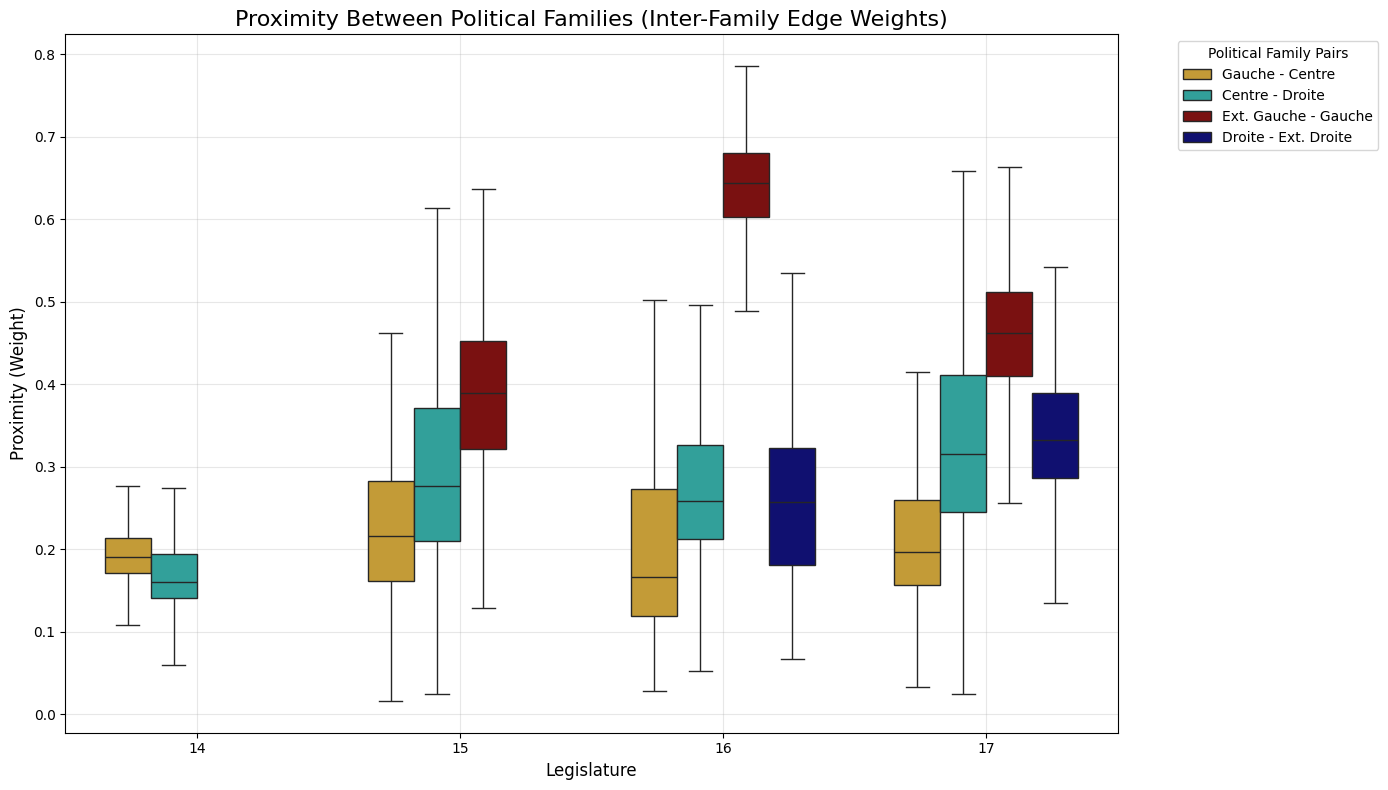

In [28]:
def plot_political_family_proximity(legislatures_graphs):
    # Mapping configuration based on the prompt
    family_config = {
        14: {
            "EG": [],
            "G": ["PO656018", "PO713077", "PO656002", "PO656014", "PO656022"],
            "C": ["PO656010"],
            "D": ["PO707869", "PO656006"],
            "ED": []
        },
        15: {
            "EG": ["PO730958"],
            "G": ["PO730940", "PO758835", "PO730946"],
            "C": ["PO774834", "PO730970", "PO744425", "PO771889", "PO759900"],
            "D": ["PO730934", "PO771923"],
            "ED": []
        },
        16: {
            "EG": ["PO800490"],
            "G": ["PO830170", "PO800526", "PO800502"],
            "C": ["PO800484", "PO800532"],
            "D": ["PO800508", "PO800514"],
            "ED": ["PO800520"]
        },
        17: {
            "EG": ["PO845413"],
            "G": ["PO845419", "PO845439", "PO845514"],
            "C": ["PO845454", "PO845485", "PO845470"],
            "D": ["PO845425"],
            "ED": ["PO845401", "PO872880", "PO847173"]
        }
    }

    # Pairs to analyze (Spectrum adjacency)
    pair_labels = {
        ("EG", "G"): "Ext. Gauche - Gauche",
        ("G", "C"): "Gauche - Centre",
        ("C", "D"): "Centre - Droite",
        ("D", "ED"): "Droite - Ext. Droite"
    }

    plot_data = []

    for leg_id, G, deputies in legislatures_graphs:
        if leg_id not in family_config:
            continue
            
        # Build node to family mapping
        node_family = {}
        current_config = family_config[leg_id]
        
        # Invert the config: party_id -> family
        party_to_family = {}
        for fam, parties in current_config.items():
            for p in parties:
                party_to_family[p] = fam
        
        for node in G.nodes():
            organ = deputies[node].get('organ')
            if organ and organ['id'] in party_to_family:
                node_family[node] = party_to_family[organ['id']]
        
        # Iterate edges to find inter-family connections
        for u, v, data in G.edges(data=True):
            if u in node_family and v in node_family:
                fam_u = node_family[u]
                fam_v = node_family[v]
                
                if fam_u != fam_v:
                    # Sort to ensure consistent key
                    fam_order = ["EG", "G", "C", "D", "ED"]
                    if fam_u in fam_order and fam_v in fam_order:
                        pair = tuple(sorted([fam_u, fam_v], key=lambda x: fam_order.index(x)))
                        
                        if pair in pair_labels:
                            plot_data.append({
                                "Legislature": leg_id,
                                "Family Pair": pair_labels[pair],
                                "Proximity": data['weight']
                            })

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 8))
    
    # Custom palette for the pairs
    # EG(DarkRed)-G(Red) -> DarkRed
    # G(Red)-C(Green) -> Orange/Gold (Transition)
    # C(Green)-D(Blue) -> Teal/Turquoise (Transition)
    # D(Blue)-ED(DarkBlue) -> Navy/DarkBlue
    palette = {
        "Ext. Gauche - Gauche": "darkred", 
        "Gauche - Centre": "goldenrod",      
        "Centre - Droite": "lightseagreen",      
        "Droite - Ext. Droite": "navy"  
    }

    sns.boxplot(data=df, x="Legislature", y="Proximity", hue="Family Pair", 
                palette=palette, showfliers=False, width=0.7)
    
    plt.title("Proximity Between Political Families (Inter-Family Edge Weights)", fontsize=16)
    plt.ylabel("Proximity (Weight)", fontsize=12)
    plt.xlabel("Legislature", fontsize=12)
    plt.legend(title="Political Family Pairs", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Prepare data: (Legislature ID, Graph, Deputies Data)
legs_graphs_data = [
    (14, G_14, legislature_14["deputies"]),
    (15, G_15, legislature_15["deputies"]),
    (16, G_16, legislature_16["deputies"]),
    (17, G_17, legislature_17["deputies"])
]

plot_political_family_proximity(legs_graphs_data)

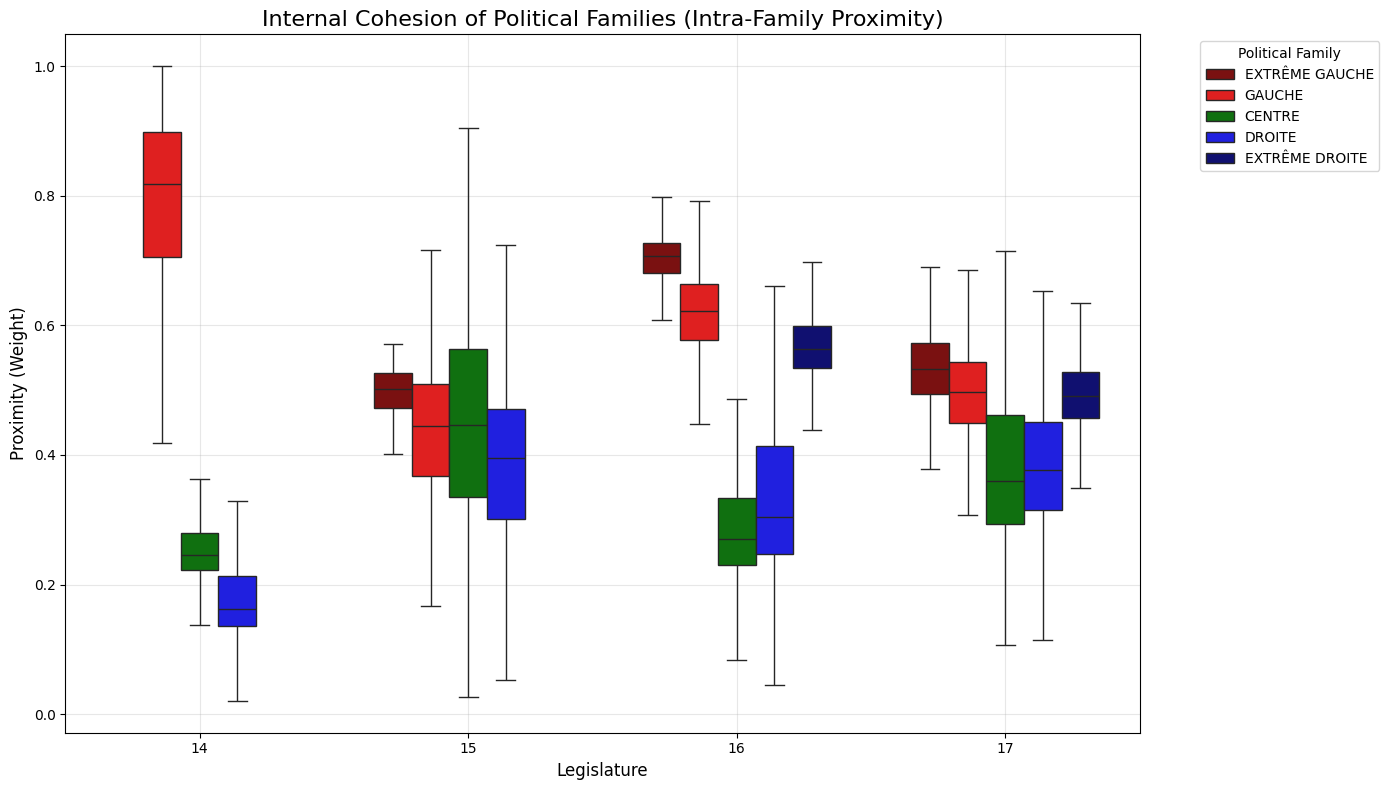

In [29]:
def plot_political_family_internal_cohesion(legislatures_graphs):
    # Mapping configuration based on the prompt
    family_config = {
        14: {
            "EXTRÊME GAUCHE": [],
            "GAUCHE": ["PO656018", "PO713077", "PO656002", "PO656014", "PO656022"],
            "CENTRE": ["PO656010"],
            "DROITE": ["PO707869", "PO656006"],
            "EXTRÊME DROITE": []
        },
        15: {
            "EXTRÊME GAUCHE": ["PO730958"],
            "GAUCHE": ["PO730940", "PO758835", "PO730946"],
            "CENTRE": ["PO774834", "PO730970", "PO744425", "PO771889", "PO759900"],
            "DROITE": ["PO730934", "PO771923"],
            "EXTRÊME DROITE": []
        },
        16: {
            "EXTRÊME GAUCHE": ["PO800490"],
            "GAUCHE": ["PO830170", "PO800526", "PO800502"],
            "CENTRE": ["PO800484", "PO800532"],
            "DROITE": ["PO800508", "PO800514"],
            "EXTRÊME DROITE": ["PO800520"]
        },
        17: {
            "EXTRÊME GAUCHE": ["PO845413"],
            "GAUCHE": ["PO845419", "PO845439", "PO845514"],
            "CENTRE": ["PO845454", "PO845485", "PO845470"],
            "DROITE": ["PO845425"],
            "EXTRÊME DROITE": ["PO845401", "PO872880", "PO847173"]
        }
    }

    plot_data = []

    for leg_id, G, deputies in legislatures_graphs:
        if leg_id not in family_config:
            continue
            
        # Build node to family mapping
        node_family = {}
        current_config = family_config[leg_id]
        
        # Invert the config: party_id -> family
        party_to_family = {}
        for fam, parties in current_config.items():
            for p in parties:
                party_to_family[p] = fam
        
        for node in G.nodes():
            organ = deputies[node].get('organ')
            if organ and organ['id'] in party_to_family:
                node_family[node] = party_to_family[organ['id']]
        
        # Iterate edges to find intra-family connections
        for u, v, data in G.edges(data=True):
            if u in node_family and v in node_family:
                fam_u = node_family[u]
                fam_v = node_family[v]
                
                if fam_u == fam_v:
                    plot_data.append({
                        "Legislature": leg_id,
                        "Political Family": fam_u,
                        "Proximity": data['weight']
                    })

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 8))
    
    # Custom palette
    palette = {
        "EXTRÊME GAUCHE": "darkred", 
        "GAUCHE": "red",      
        "CENTRE": "green",      
        "DROITE": "blue",
        "EXTRÊME DROITE": "navy"
    }

    # Order for the legend/plot
    family_order = ["EXTRÊME GAUCHE", "GAUCHE", "CENTRE", "DROITE", "EXTRÊME DROITE"]

    sns.boxplot(data=df, x="Legislature", y="Proximity", hue="Political Family", 
                hue_order=family_order, palette=palette, showfliers=False, width=0.7)
    
    plt.title("Internal Cohesion of Political Families (Intra-Family Proximity)", fontsize=16)
    plt.ylabel("Proximity (Weight)", fontsize=12)
    plt.xlabel("Legislature", fontsize=12)
    plt.legend(title="Political Family", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Prepare data: (Legislature ID, Graph, Deputies Data)
legs_graphs_data = [
    (14, G_14, legislature_14["deputies"]),
    (15, G_15, legislature_15["deputies"]),
    (16, G_16, legislature_16["deputies"]),
    (17, G_17, legislature_17["deputies"])
]

plot_political_family_internal_cohesion(legs_graphs_data)